# **DTSA 5511 Introduction to Deep Learning Final Project**

## **Problem Defenition**



#### **Data Gathering and Provenance**
The data source is from Kaggle under the title [Vehicle Type Recognition](https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition). I have picked this data because it is related to a Deep Learning problem, and found it suitable to test many deep learning algorithm and to generate a comparision between them on this [notebook](https://github.com/laithrasheed/DTSA_5511_Introduction_to_Deep_Learning_Final_Project).<br><br>

#### **Identifying the Deep Learning problem**
Let's understand together the problem we have here by first identifying what is the objective of the problem. 
In this case, we have a vehicle image classification dataset that contians four classes, Car, Truck, Bus, and Motoecycle. Each class has 100 image, such that and based to the author of this dataset, each image has different type model, being captured in different vision angles, and in different lightning situations.<br><br>



## **Exploratory Data Analysis(EDA) Part**

#### **Importing Needed Libraries**

In [1]:
# please note that all the needed libraries throughout the project are imported in this cell.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import cv2
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, MobileNetV2
from sklearn.model_selection import train_test_split
!pip install keras-tuner
import keras_tuner
from keras_tuner import RandomSearch
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import BatchNormalization

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

#### **Data Overview**

In [2]:
data_path = '/kaggle/input/vehicle-type-recognition/Dataset'

# Get the number of images and classes
class_names = os.listdir(data_path)
num_classes = len(class_names)

# Get the image dimensions
image_path = os.path.join(data_path, class_names[0], os.listdir(os.path.join(data_path, class_names[0]))[0])
sample_image = cv2.imread(image_path)
image_height, image_width, image_channels = sample_image.shape

print("Number of classes:", num_classes)
print("Image dimensions (height, width, channels):", image_height, image_width, image_channels)

Number of classes: 4
Image dimensions (height, width, channels): 1000 1000 3


#### **Class Distribution**

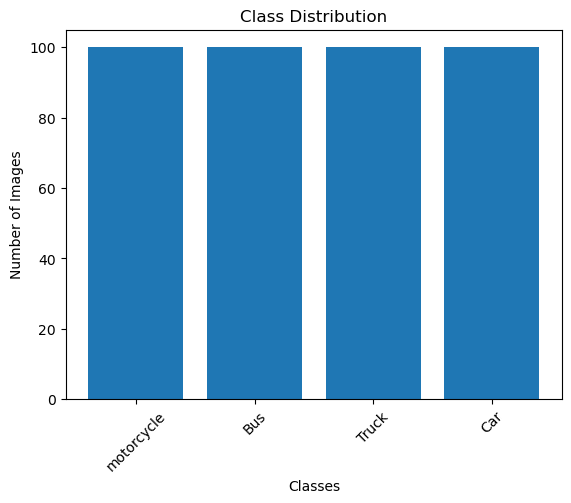

In [3]:


class_counts = [len(os.listdir(os.path.join(data_path, class_name))) for class_name in class_names]

plt.bar(class_names, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

#### **Sample Image Display**

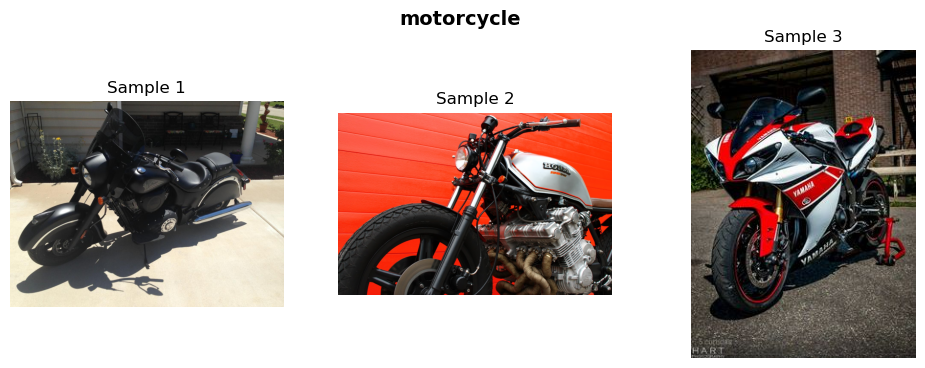

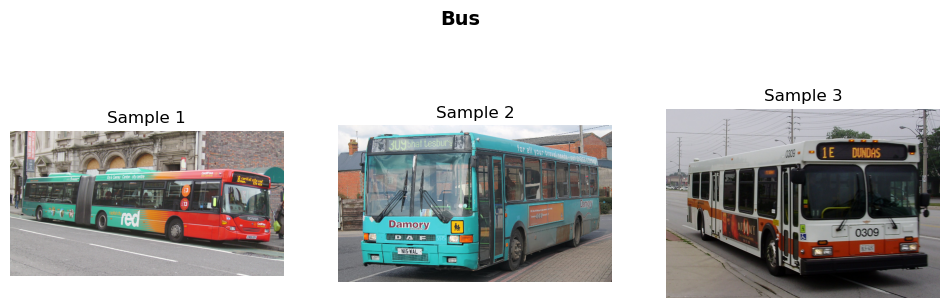

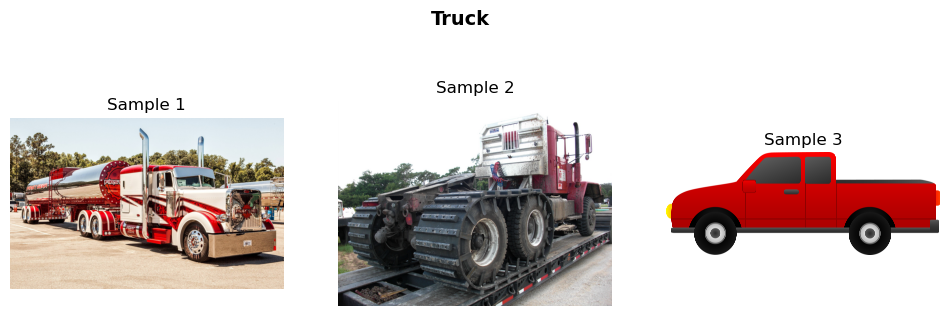

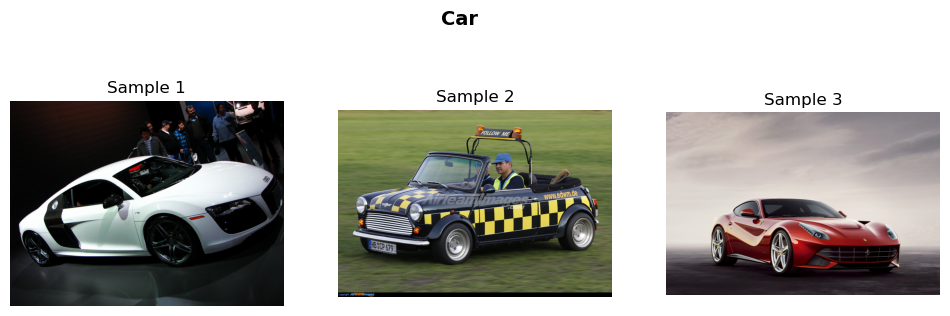

In [4]:
num_samples_per_class = 3

for class_name in class_names:
    class_path = os.path.join(data_path, class_name)
    image_filenames = os.listdir(class_path)
    random.shuffle(image_filenames)
    
    fig, axs = plt.subplots(1, num_samples_per_class, figsize=(12, 4))
    
    for i in range(num_samples_per_class):
        image_path = os.path.join(class_path, image_filenames[i])
        sample_image = cv2.imread(image_path)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
        
        axs[i].imshow(sample_image)
        axs[i].axis('off')
        axs[i].set_title(f'Sample {i+1}')
    
    fig.suptitle(class_name, fontsize=14, fontweight='bold')
    plt.show()

#### **Image Statistics**

In [5]:
image_stats = []

for class_name in class_names:
    class_path = os.path.join(data_path, class_name)
    image_filenames = os.listdir(class_path)

    for image_filename in image_filenames:
        image_path = os.path.join(class_path, image_filename)
        image = cv2.imread(image_path)
        image_stats.append(image.mean(axis=(0, 1)))

image_stats = np.array(image_stats)
mean_stats = image_stats.mean(axis=0)
std_stats = image_stats.std(axis=0)

print("Mean pixel values:", mean_stats)
print("Standard deviation of pixel values:", std_stats)

Mean pixel values: [114.06713775 118.03303583 123.34488098]
Standard deviation of pixel values: [41.74682924 39.56793569 40.1888138 ]


## **Deep Learning Models**

 I am going to implement several deep learning algorithms and compare them in terms of the evaluation metrics and complexity running time, note that I have used a value of 10 for every Epochs in each model, because of the purpose of this project which is displaying  the implementation of several types of deep learning  models such that I am not going to submit my project in Kaggle, because my priority in this project is to show several models with comparison not submit a high score. Also, as I mentioned in the problem definition that this dataset is not for competition. 
 
 please note that I have picked a random models that came up while I was searching for many many topics under deep learning algorithms, such that I have mentioned the references in the last of this project , so you can refer to the documentation of each model I have used for further readings on the concept of the model, such that this dataset is not a famous one and you will not find much online solutions submitted by others either on Kaggle or in the documentation reference I have mentioned in references.

#### **Data Preparation and Dataset Loading**

In [6]:
# Retrieving class names and loading the dataset
class_names = sorted(os.listdir('/kaggle/input/vehicle-type-recognition/Dataset'))
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))

image_width = 224
image_height = 224
channels = 3
batch_size = 32
random_seed = 1

data_generator = ImageDataGenerator(rescale=1.0 / 255,validation_split=0.2)

train_data = data_generator.flow_from_directory(directory='/kaggle/input/vehicle-type-recognition/Dataset',target_size=(image_width, image_height),batch_size=batch_size,class_mode='categorical',subset='training',shuffle=True,seed=random_seed)

validation_data = data_generator.flow_from_directory(directory='/kaggle/input/vehicle-type-recognition/Dataset',target_size=(image_width, image_height),batch_size=batch_size,class_mode='categorical',subset='validation',shuffle=True,seed=random_seed)

print('Train Dataset Length:', len(train_data))
print('Validation Dataset Length:', len(validation_data))

Class Names: ['Bus', 'Car', 'Truck', 'motorcycle']
Number of Classes: 4
Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Train Dataset Length: 10
Validation Dataset Length: 3


### **CNN**

In [7]:


# Set the seed for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

# Set the dataset and model parameters
data_dir = '/kaggle/input/vehicle-type-recognition/Dataset'
image_width = 224
image_height = 224
channels = 3
batch_size = 32
random_seed = 1

# Data augmentation and preprocessing
data_generator = ImageDataGenerator(rescale=1.0 / 255,validation_split=0.2)

train_data = data_generator.flow_from_directory(directory=data_dir,target_size=(image_width, image_height), batch_size=batch_size,class_mode='categorical',subset='training',shuffle=True,seed=random_seed)

validation_data = data_generator.flow_from_directory(directory=data_dir,target_size=(image_width, image_height),batch_size=batch_size,class_mode='categorical',subset='validation',shuffle=True,seed=random_seed)

class_names = sorted(train_data.class_indices.keys())

# Define the CNN model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))

# Compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Train the model
model.fit(train_data,epochs=10,validation_data=validation_data)



Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Epoch 1/10
 9/10 [==========================>...] - ETA: 0s - loss: 1.4448 - accuracy: 0.2778

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 [==============================] - 14s 856ms/step - loss: 1.4409 - accuracy: 0.2750 - val_loss: 1.3601 - val_accuracy: 0.4000
Epoch 2/10
10/10 [==============================] - 9s 962ms/step - loss: 1.3141 - accuracy: 0.4000 - val_loss: 1.2241 - val_accuracy: 0.3875
Epoch 3/10
10/10 [==============================] - 9s 874ms/step - loss: 1.2094 - accuracy: 0.4062 - val_loss: 1.1843 - val_accuracy: 0.5375
Epoch 4/10
10/10 [==============================] - 8s 875ms/step - loss: 1.1046 - accuracy: 0.5156 - val_loss: 0.9730 - val_accuracy: 0.6125
Epoch 5/10
10/10 [==============================] - 9s 920ms/step - loss: 0.9283 - accuracy: 0.6250 - val_loss: 1.0430 - val_accuracy: 0.5625
Epoch 6/10
10/10 [==============================] - 9s 887ms/step - loss: 0.7679 - accuracy: 0.7031 - val_loss: 0.9355 - val_accuracy: 0.6125
Epoch 7/10
10/10 [==============================] - 9s 889ms/step - loss: 0.6349 - accuracy: 0.7469 - val_loss: 1.1038 - val_accuracy: 0.5875
Epoch 8/10
10/10

### **Custom CNN Model with Increased Depth**
In this variation, we can increase the depth of the custom CNN model by adding more convolutional layers.

In [8]:
# Define the CNN model architecture with increased depth
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))

# Compile and train the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(train_data,epochs=10,validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 16s 1s/step - loss: 1.4165 - accuracy: 0.2906 - val_loss: 1.3837 - val_accuracy: 0.2875
Epoch 2/10
10/10 [==============================] - 9s 897ms/step - loss: 1.3849 - accuracy: 0.3094 - val_loss: 1.3786 - val_accuracy: 0.3750
Epoch 3/10
10/10 [==============================] - 9s 884ms/step - loss: 1.3727 - accuracy: 0.3219 - val_loss: 1.3312 - val_accuracy: 0.3500
Epoch 4/10
10/10 [==============================] - 9s 933ms/step - loss: 1.3498 - accuracy: 0.3969 - val_loss: 1.3777 - val_accuracy: 0.3000
Epoch 5/10
10/10 [==============================] - 9s 910ms/step - loss: 1.3490 - accuracy: 0.3313 - val_loss: 1.2243 - val_accuracy: 0.4500
Epoch 6/10
10/10 [==============================] - 9s 872ms/step - loss: 1.3361 - accuracy: 0.3562 - val_loss: 1.3128 - val_accuracy: 0.4250
Epoch 7/10
10/10 [==============================] - 9s 874ms/step - loss: 1.2936 - accuracy: 0.3938 - val_loss: 1.2115 - val_accuracy: 0.5375
Epoch 8/

### **Custom CNN Model with Batch Normalization**
Another variation is to add batch normalization layers after each convolutional layer to improve model training and convergence.

In [9]:


# Define the CNN model architecture with batch normalization
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))

# Compile and train the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(train_data,epochs=10,validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 14s 965ms/step - loss: 1.8301 - accuracy: 0.4531 - val_loss: 1.7532 - val_accuracy: 0.2625
Epoch 2/10
10/10 [==============================] - 8s 882ms/step - loss: 0.7051 - accuracy: 0.7437 - val_loss: 2.5381 - val_accuracy: 0.2875
Epoch 3/10
10/10 [==============================] - 9s 902ms/step - loss: 0.4785 - accuracy: 0.8281 - val_loss: 4.0892 - val_accuracy: 0.2500
Epoch 4/10
10/10 [==============================] - 9s 983ms/step - loss: 0.3110 - accuracy: 0.9094 - val_loss: 4.6667 - val_accuracy: 0.2500
Epoch 5/10
10/10 [==============================] - 8s 873ms/step - loss: 0.1665 - accuracy: 0.9719 - val_loss: 4.4392 - val_accuracy: 0.2500
Epoch 6/10
10/10 [==============================] - 9s 889ms/step - loss: 0.0932 - accuracy: 0.9875 - val_loss: 4.6982 - val_accuracy: 0.2500
Epoch 7/10
10/10 [==============================] - 9s 907ms/step - loss: 0.0743 - accuracy: 0.9875 - val_loss: 5.5221 - val_accuracy: 0.2500
Epoch

### **ResNet50 (Pretrained Model)**


In [10]:
# Defining the model architecture
def build_finetune_model(hp):
    base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(image_width, image_height, channels))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(len(class_names), activation='softmax'))

    optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'nadam', 'adadelta'])
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [11]:

# Performing hyperparameter tuning
tuner = RandomSearch(build_finetune_model,objective='val_accuracy',max_trials=5,executions_per_trial=1,directory='./',project_name='vehicle_type_recognition')

tuner.search(train_data,epochs=10,validation_data=validation_data)

best_hyperparameters = tuner.get_best_hyperparameters()[0].values
best_model = tuner.get_best_models(num_models=1)[0]

print("Best Hyperparameters:", best_hyperparameters)

Trial 5 Complete [00h 01m 41s]
val_accuracy: 0.737500011920929

Best val_accuracy So Far: 0.75
Total elapsed time: 00h 07m 07s
Best Hyperparameters: {'optimizer': 'nadam'}


In [12]:
# Training the best model
best_model.fit(train_data,epochs=10,validation_data=validation_data)

# Evaluation on the test dataset
test_data = data_generator.flow_from_directory(directory=data_dir,target_size=(image_width, image_height),batch_size=batch_size,class_mode='categorical',subset='validation',shuffle=False)

test_predictions = model.predict(test_data)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_data.classes



Epoch 1/10


2023-08-20 08:31:47.307060: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 14s 1s/step - loss: 0.5667 - accuracy: 0.7750 - val_loss: 0.9759 - val_accuracy: 0.6500
Epoch 2/10
10/10 [==============================] - 9s 893ms/step - loss: 0.5589 - accuracy: 0.7531 - val_loss: 1.1946 - val_accuracy: 0.6125
Epoch 3/10
10/10 [==============================] - 9s 918ms/step - loss: 0.4581 - accuracy: 0.8125 - val_loss: 0.8628 - val_accuracy: 0.7125
Epoch 4/10
10/10 [==============================] - 9s 937ms/step - loss: 0.3772 - accuracy: 0.8500 - val_loss: 0.8529 - val_accuracy: 0.7250
Epoch 5/10
10/10 [==============================] - 9s 890ms/step - loss: 0.3826 - accuracy: 0.8656 - val_loss: 0.8718 - val_accuracy: 0.7000
Epoch 6/10
10/10 [==============================] - 9s 936ms/step - loss: 0.3092 - accuracy: 0.8938 - val_loss: 0.8054 - val_accuracy: 0.7375
Epoch 7/10
10/10 [==============================] - 9s 823ms/step - loss: 0.2984 - accuracy: 0.9031 - val_loss: 0.9281 - val_accuracy: 0.6875
Epoch 8/10
10/10 [=

### **MobileNetV2**

In [13]:
# Retrieving class names and loading the dataset
class_names = sorted(os.listdir('/kaggle/input/vehicle-type-recognition/Dataset'))
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))

image_width = 224
image_height = 224
channels = 3
batch_size = 32
random_seed = 1

data_generator = ImageDataGenerator(rescale=1.0 / 255,validation_split=0.2)

train_data = data_generator.flow_from_directory(directory='/kaggle/input/vehicle-type-recognition/Dataset',target_size=(image_width, image_height),batch_size=batch_size,class_mode='categorical',subset='training',shuffle=True,seed=random_seed)

validation_data = data_generator.flow_from_directory(directory='/kaggle/input/vehicle-type-recognition/Dataset',target_size=(image_width, image_height),batch_size=batch_size,class_mode='categorical',subset='validation',shuffle=True,seed=random_seed)

print('Train Dataset Length:', len(train_data))
print('Validation Dataset Length:', len(validation_data))

# Model using MobileNetV2 architecture
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_width, image_height, channels))

for layer in base_model.layers:
    layer.trainable = False

model = keras.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))

model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

# Training the model
model.fit(train_data,epochs=10,validation_data=validation_data)


Class Names: ['Bus', 'Car', 'Truck', 'motorcycle']
Number of Classes: 4
Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Train Dataset Length: 10
Validation Dataset Length: 3
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
10/10 [==============================] - 13s 1s/step - loss: 8.1600 - accuracy: 0.6344 - val_loss: 0.5454 - val_accuracy: 0.9375
Epoch 2/10
10/10 [==============================] - 9s 897ms/step - loss: 0.4702 - accuracy: 0.9469 - val_loss: 0.2634 - val_accuracy: 0.9750
Epoch 3/10
10/10 [==============================] - 9s 952ms/step - loss: 0.0815 - accuracy: 0.9844 - val_loss: 0.2462 - val_accuracy: 0.9750
Epoch 4/10
10/10 [==============================] - 8s 874ms/step - loss: 0.0393 - accuracy: 0.9906 - val_loss: 0.1666 - val_accuracy: 0.9625
Epoch 5/10
10/10 [==============================] - 8s 884ms/step - loss: 0.1140 - accuracy: 0.9906 - val_loss: 0.3869 - val_accuracy: 0.9750
Epoch 6/10
10/10 [====

### **EfficientNetB0 (Transfer Learning)**
EfficientNet is a family of convolutional neural networks that have achieved state-of-the-art performance with efficient model architecture. In this case, we will use the EfficientNetB0 model for transfer learning.

In [14]:
# Defining the model architecture
def build_efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_width, image_height, channels))
    
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(class_names), activation='softmax'))

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

# Training the model
efficientnet_model = build_efficientnet_model()
efficientnet_model.fit(train_data,epochs=10,validation_data=validation_data)



16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/10


2023-08-20 08:35:26.270343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 18s 1s/step - loss: 9.9524 - accuracy: 0.2500 - val_loss: 4.0009 - val_accuracy: 0.2500
Epoch 2/10
10/10 [==============================] - 9s 941ms/step - loss: 2.6912 - accuracy: 0.3031 - val_loss: 1.5911 - val_accuracy: 0.2500
Epoch 3/10
10/10 [==============================] - 9s 902ms/step - loss: 1.4310 - accuracy: 0.1937 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 4/10
10/10 [==============================] - 9s 794ms/step - loss: 1.3863 - accuracy: 0.2156 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 5/10
10/10 [==============================] - 9s 920ms/step - loss: 1.3863 - accuracy: 0.2281 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 6/10
10/10 [==============================] - 9s 868ms/step - loss: 1.4599 - accuracy: 0.2188 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 7/10
10/10 [==============================] - 8s 902ms/step - loss: 1.3863 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 8/10
10/10 [=

## **Models Comparison, Analysis, and Conclusions**<br><br>
#### **Introduction**
In this section I have implemented 6 deep learning models as follows :

###### 1- Convolutional Neural Network(CNN) 

###### 2- Custom CNN Model with Increased Depth

###### 3- Custom CNN Model with Batch Normalization

###### 4- ResNet50 (Pre-trained Model)

###### 5- MobileNetV2

###### 6- EfficientNetB0 (Transfer Learning)<br><br>

#### **My Criteria of Evaluation**
Let us first confirm that evaluation criteria for the models between each other, such that I am m going to analyse the value of **loss** and value of the **accuracy**  for each model performed , and then compare the result of the analysis with other implemented models in this project, such that I am focusing on the learning indication of the model to figure out what proper models should come first to our mind when implementing such kinds of projects. 

please note that as I mentioned earlier there are much more deep learning models, and I have selected those 6 models based on the searching I have made and my understanding to the documentation of each model. Also, please find **references** for each model in the references section at the end of this notebook.<br><br>


#### **Results Analysis**

In the first model **CNN** we can find the loss value at Epoch 1 equals to 1.4448, then it starts to decrease in a low rate until Epoch 5 , such that we observe a higher rate of decreasing until reaching Epoch 10 with a value of 0.3694.

Regarding the accuracy values, we observe we have started with 0.2750 at Epoch 1 , ending up with 0.8750. 

in a conclusion for the first model **CNN** we can say that there is a possible higher accuracy value by increasing the number of Epochs. 

I am going to perform the same model implementation by increasing the Epochs, such that the purpose is to compare among best models if **CNN** can generate the highest accuracy value or not as at 10 Epochs, we found it relatively an accepted model. <span style="color:red">Footnote 1</span>

Finally, we check the model in terms of time complexity, we can find that for 10 Epochs average time is 9.3 seconds per Epoch.<br><br>

In the second model **Custom CNN Model with Increased Depth** we can find the loss value at Epoch 1 equals to 1.4165( as  starting it is better than **CNN**), then it starts to decrease in a low rate until Epoch 8 (it took more epochs than **CNN** to develop learning rate), such that we observe a higher rate of decreasing until reaching Epoch 10 with a value of 0.9939(much higher than **CNN**, indicating that it needs much more Epochs to develop more learning).

Regarding the accuracy values, we observe we have started with 0.2906 at Epoch 1 (higher compared to **CNN** as a start), ending up with 0.5906(much lower than **CNN**). 

in a conclusion for this second model, we can say that there is no  possible higher accuracy value even by increasing the number of Epochs **compared to CNN**. 

for this model, I think I will not get benefits for increasing Epochs in terms of accuracy, so in my comparison I am going to place this model in the bottom of the list until discovering the other results of the remaining 4 models! 

Finally, let us have a look16 the model in terms of time complexity, we can find that for 10 Epochs average time is 9.6 seconds per Epoch, relatively more complex than CNN!<br><br>

In the third model **Custom CNN Model with Batch Normalization** we can find the loss value at Epoch 1 equals to 1.8301 (much higher than **CNN**), then it severely decreased to 0.7051 at Epoch 2 !! and then keep decreasing in a higher rate than **CNN** until reaching a value of 0.0329(which is much lower and **better than CNN**).


Regarding the accuracy values, we observe we have started with 0.4531 at Epoch 1(higher than **CNN**) , ending up with a value of 0.9969 (which is **better than CNN**). 

in a conclusion for this third model,  we can say that for only 10 Epochs the model obtain a value of 0.9969 which is almost 1!



Finally, we check the model in terms of time complexity, we can find that for 10 Epochs average time is 9.3 seconds per Epoch, which is the same with CNN !! i.e., this model gives higher accuracy with same complexity than CNN model.<br><br>


In the fourth model **ResNet50** which is a pre-trained deep learning model based on the ResNet architecture that has been trained on a large dataset. It is usually used as a feature extractor for **transfer learning tasks**. I have a kept a resource for extra information about Transfer learning found in the reference sections, which is where I knew about this type of learning.

Back to the analysis we can find the loss value at Epoch 1 equals to 0.5667(which is the lowest value up to this model), then in all Epoches from 1 to 10 the value normally decreased reaching a value of 0.2140 at Epoch 10 (which is much higher than the **Custom CNN with Batch Normalization Model**) 

Regarding the accuracy values, we observe we have started with 0.7750 at Epoch 1(which is much higher than all previous models , ending up with 0.9438 (which is **lower than the accuracy value of Custom CNN with Batch Normalization Model**). 

in a conclusion for this fourth model * we can say it generate a satisfied accuracy at 10 Epochs, but the previous model generated a little higher accuracy value at Epoch 10.  

Finally, we check the model in terms of time complexity, we can find that for 10 Epochs average time is 9.5 seconds per Epoch, which is more complex than the custom CNN model with batch normalization!<br><br>


In the fifth model **MobileNetV2** we can find the loss value at Epoch 1 equals to 8.1600(which is **extremely** higher than other previous models), then directly at Epoch 2, it significantly decrease to a value of 0.4, then another significant decrease at Epoch 5 with a value of almost 0, which we stop up to this Epoch.

Regarding the accuracy values, we observe we have started with 0.6344 at Epoch 1 (higher than all previous models but lower than ResNet50), directly at Epoch 2 it generate an accuracy value with 0.9469, which is **higher than the accuracy value of ResNet50 Model at Epoch 10!** the model continues to increase until reaches an accuracy value of 1.0000 at Epoch 6!!   

in a conclusion for this fifth model, we can say that it is the best model for the Vehicle Type Recognition dataset, the models obtained an accuracy value with at Epoch 6 , in terms of time complexity the average time of learning equals to 9.167 seconds per epoch (note that number epochs is equal to 6 for this mean value calculation), which is the  less model time complexity.<br><br>

In the final and sixth model **EfficientNetB0** which is another model under Transfer Learning. 

we can find the loss value at Epoch 1 equals to 9.9524 (which is the highest value among all models), then it starts severely decrease to 2.6912 loss value at Epoch 2, but up the tenth Epoch no significant decreasing in the value indicating that the model is not effectively learning ending to a loss value with 1.5131 (which is relatively much higher than other models).

Regarding the accuracy values, we observe we have started with 0.2500 at Epoch 1 (**lowest**among all previous models, ending up with same value at Epoch 10, while the highest value among the first 10 Epochs is 0.3031 at Epoch 2. this indicates that either the model is completely not suitable for our case or it needs further data preprocessing and hyperparameter tuning more than the criteria implemented here in this notebook!

in a conclusion for this final and sixth model, this would be the worst model for the current case, no significant improving in the learning rate and much low accuracy value compared with other models.  

Finally, we check the model in terms of time complexity, we can find that for 10 Epochs average time is 9.8 seconds per Epoch which is the most complex model for this dataset in term of time complexity.<br><br>

#### **Discussions and Conclusions**

- As we observed  we can say that **MobileNetV2** model is the best Deep Learning model for this case, it has a 1.0000 accuracy value at Epoch 6. 

- an outcome is that we can reach a high accuracy even with low number of Epochs.

- This project is around 170 MB data size, I believe for as a student delivering the final project for an Introduction to Deep Learning course, it is the key project where I ca start learning and applying much higher dataset, as I understood some few models implemented here by analysing their learning rate and at which point the model generates the best accuracy value.



<span style="color:red">Footnote 1</span>

- you can find out below, that the **CNN** model obtains an accuracy value with 1.0000 at Epoch 23.

In [15]:


# Set the seed for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

# Set the dataset and model parameters
data_dir = '/kaggle/input/vehicle-type-recognition/Dataset'
image_width = 224
image_height = 224
channels = 3
batch_size = 32
random_seed = 1

# Data augmentation and preprocessing
data_generator = ImageDataGenerator(rescale=1.0 / 255,validation_split=0.2)

train_data = data_generator.flow_from_directory(directory=data_dir,target_size=(image_width, image_height), batch_size=batch_size,class_mode='categorical',subset='training',shuffle=True,seed=random_seed)

validation_data = data_generator.flow_from_directory(directory=data_dir,target_size=(image_width, image_height),batch_size=batch_size,class_mode='categorical',subset='validation',shuffle=True,seed=random_seed)

class_names = sorted(train_data.class_indices.keys())

# Define the CNN model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))

# Compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Train the model
model.fit(train_data,epochs=50,validation_data=validation_data)



Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Epoch 1/50
10/10 [==============================] - 11s 859ms/step - loss: 1.7528 - accuracy: 0.2469 - val_loss: 1.3757 - val_accuracy: 0.2500
Epoch 2/50
10/10 [==============================] - 8s 828ms/step - loss: 1.3867 - accuracy: 0.2937 - val_loss: 1.3846 - val_accuracy: 0.2500
Epoch 3/50
10/10 [==============================] - 9s 948ms/step - loss: 1.3572 - accuracy: 0.3531 - val_loss: 1.3690 - val_accuracy: 0.3250
Epoch 4/50
10/10 [==============================] - 8s 857ms/step - loss: 1.2979 - accuracy: 0.4062 - val_loss: 1.2525 - val_accuracy: 0.3750
Epoch 5/50
10/10 [==============================] - 8s 828ms/step - loss: 1.1649 - accuracy: 0.4781 - val_loss: 1.0713 - val_accuracy: 0.5250
Epoch 6/50
10/10 [==============================] - 9s 902ms/step - loss: 1.0026 - accuracy: 0.5781 - val_loss: 1.0818 - val_accuracy: 0.5375
Epoch 7/50
10/10 [==============================] - 8s 792ms/step 

## **Reference**
[My GitHub Repository](https://github.com/laithrasheed/DTSA_5511_Introduction_to_Deep_Learning_Final_Project.git)

[Vehicle Type Recognition Dataset | Kaggle](https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition)

[CNN Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)

[CNN TensorFlow](https://www.tensorflow.org/tutorials/images/cnn)

[Image Classification TensorFlow](https://www.tensorflow.org/tutorials/images/classification)

[Transfer Learning Wikipedia](https://en.wikipedia.org/wiki/Transfer_learning#:~:text=Transfer%20learning%20(TL)%20is%20a,when%20trying%20to%20recognize%20trucks.)

[Transfer Learning TensorFlow](https://www.tensorflow.org/tutorials/images/transfer_learning)

[Custom CNN with Depth Increasing](https://stackoverflow.com/questions/38177103/interpretation-of-depth-in-convolutional-neural-network)

[Custom CNN with Batch Normalization stackoverflow](https://stackoverflow.com/questions/38553927/batch-normalization-in-convolutional-neural-network)

[Custom CNN with Batch Normalization TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

[Residual Neural Network 'ResNet50'](https://en.wikipedia.org/wiki/Residual_neural_network)

[Residual Neural Network 'ResNet50' TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)

[Residual Neural Network Kaggle](https://www.kaggle.com/code/shivamsingh17072001/vehicle-detection-via-resnet-0-9667-val-accuracy)

[Residual Neural Network 'ResNet50' stackoverflow](https://stackoverflow.com/questions/67701192/transfer-learning-with-resnet50-for-image-classification)

[One Shot Models 'MobileNetV2'](https://en.wikipedia.org/wiki/Neural_architecture_search#One-shot_models)

[MobileNet TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/MobileNet)

[MobileNetV2 stackoverflow](https://stackoverflow.com/questions/69983272/mobilenetv2-is-giving-good-results-during-training-and-validation-but-when-test)

[EfficientNet stackoverflow](https://stackoverflow.com/questions/67608988/unable-to-use-efficientnet-with-transfer-learning)

[EfficientNEtBo TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0)
